# Pattern Recognition in Financial Data: Sample Work

In [2]:
# Install hdf5 library by interacting with the interpreter 
import sys
!{sys.executable} -m pip install hdf5storage
!{sys.executable} -m pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.2 MB/s eta 0:00:00


In [3]:
# Import Libraries 
import hdf5storage
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

2024-08-20 21:47:57.165739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

KeyboardInterrupt



# 1. Data Preparation

## 1.1 Extracting Data File

In [ ]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
#filename and output redacted since file is sensitive

LOB_input = hdf5storage.loadmat('[redacted].mat') 
LOB_data = pd.DataFrame.from_dict(LOB_input['LOB'])
display(LOB_data.iloc[20000:20006, 0: ]) #display a well populated sample - randomly selected

### 3.1.1 Assign Column Names

In [4]:
#The data frame uses column references as headings and it is not easy to identify what column represents.
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
#Add Column Titles
    
LOB_data.columns = [
                      "Time", "Mid_Price", "Spread", 
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10", # Level 10
                     ]

LOB_data.iloc[20000:20006, 0: ]

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
20000,1442896085227,5220500,456000,5448500,100,4992500,100,5475200,100,0,...,0,0,0,0,0,0,0,0,0,0
20001,1442896085239,5233850,482700,5475200,100,4992500,100,5487400,200,0,...,0,0,0,0,0,0,0,0,0,0
20002,1442896085239,5221050,457100,5449600,100,4992500,100,5475200,100,0,...,0,0,0,0,0,0,0,0,0,0
20003,1442896085239,5221050,457100,5449600,100,4992500,100,5487400,200,0,...,0,0,0,0,0,0,0,0,0,0
20004,1442896085239,5220500,456000,5448500,100,4992500,100,5449600,100,0,...,0,0,0,0,0,0,0,0,0,0
20005,1442896085239,5220500,456000,5448500,100,4992500,100,5487400,200,0,...,0,0,0,0,0,0,0,0,0,0


### 3.1.2 Convert Epoch Time into Readable Format

In [5]:
#The column index 0 is time column (refer point a). This time is not in a readable format and we should
#update this as well.

#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Conversion module

# Version 1.0
new_time_column = []
for item in LOB_data["Time"]:
    current_row = datetime.datetime.fromtimestamp(item/1000.0) #1000.0 since 1 sec = 1000 mls
    new_time_column.append(current_row)

# Version 2.0
readable_time = []
for i in range(0,len(new_time_column)):
    current_time = new_time_column[i].strftime("%H:%M:%f")
    readable_time.append(current_time)
    
LOB_data['Time'] = readable_time 

display(LOB_data.iloc[20000:20006, 0: ])
print(110*'*')

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
20000,09:58:227000,5220500,456000,5448500,100,4992500,100,5475200,100,0,...,0,0,0,0,0,0,0,0,0,0
20001,09:58:239000,5233850,482700,5475200,100,4992500,100,5487400,200,0,...,0,0,0,0,0,0,0,0,0,0
20002,09:58:239000,5221050,457100,5449600,100,4992500,100,5475200,100,0,...,0,0,0,0,0,0,0,0,0,0
20003,09:58:239000,5221050,457100,5449600,100,4992500,100,5487400,200,0,...,0,0,0,0,0,0,0,0,0,0
20004,09:58:239000,5220500,456000,5448500,100,4992500,100,5449600,100,0,...,0,0,0,0,0,0,0,0,0,0
20005,09:58:239000,5220500,456000,5448500,100,4992500,100,5487400,200,0,...,0,0,0,0,0,0,0,0,0,0


**************************************************************************************************************


The data file has now been prepared with column names distinctly identified and time in a readable format.

## 3.2 Extracting Feature Matrix

### Initial Feature Matrix

Empricially, we know that the limit order book is based on the ask price and bid price, alongwith their corresponding volume orders. The limit order works with the best ask and bid price for execution of a limit order. Therefore, as our initial feature input, we will assume all 10 levels of price and volume i.e. all 40 features.

In [6]:
# Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh

# Identify feature columns

LOB_sample = LOB_data.iloc[552498:562500,]

feature_1 = LOB_sample.iloc[1:-1, 3:] 
print('Length i.e. number of rows of data for the feature matrix:', len(feature_1))
print("\n")
display(feature_1.head())
print(110*'-')

Length i.e. number of rows of data for the feature matrix: 10000




,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,AskPrice3,AskVolume3,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
552499,5384800,98,5381500,100,5386800,100,5381400,421,5387300,100,...,5379200,200,5389900,100,5379100,11,5390000,400,5378900,100
552500,5384800,98,5381500,100,5386800,100,5381400,421,5387300,100,...,5379200,200,5389900,100,5379100,11,5390000,400,5378900,100
552501,5384800,98,5381500,100,5386800,100,5381400,421,5387300,100,...,5379200,200,5389900,100,5379100,11,5390000,400,5378900,100
552502,5384800,98,5381500,100,5386800,100,5381400,421,5387300,100,...,5379200,200,5389900,100,5378900,100,5390000,400,5378700,100
552503,5384800,98,5381500,100,5386800,100,5381400,421,5387300,100,...,5379200,200,5389900,100,5378900,100,5390000,400,5378700,100


--------------------------------------------------------------------------------------------------------------


## 3.3 Feature Scaling

In [7]:
display(feature_1.describe())
print(110*'-')

,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,AskPrice3,AskVolume3,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
count,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.0000,1.000000e+04,10000.000000,...,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000
mean,5.384161e+06,116.453400,5.380344e+06,29.526600,5.384546e+06,107.624700,5.379731e+06,111.5313,5.385430e+06,102.202800,...,5.352754e+06,57.631400,5.399060e+06,107.008600,5.344367e+06,80.889700,5.401021e+06,159.060300,5.336363e+06,75.435200
std,1.540452e+03,148.986851,1.910179e+03,90.976573,1.668259e+03,74.123726,1.975588e+03,141.9346,1.825750e+03,52.829677,...,1.396431e+04,128.000045,1.333378e+04,444.642217,1.627885e+04,280.948929,1.998104e+04,364.573154,2.127233e+04,298.694716
min,5.365800e+06,1.000000,5.365400e+06,2.000000,5.370000e+06,5.000000,5.365200e+06,2.0000,5.380000e+06,5.000000,...,5.210000e+06,1.000000,5.385200e+06,5.000000,5.192600e+06,1.000000,5.385400e+06,5.000000,5.010000e+06,1.000000
25%,5.384200e+06,100.000000,5.380500e+06,10.000000,5.384300e+06,100.000000,5.379900e+06,100.0000,5.385100e+06,100.000000,...,5.347300e+06,25.000000,5.397700e+06,10.000000,5.339100e+06,25.000000,5.398500e+06,100.000000,5.330000e+06,3.000000
50%,5.384200e+06,100.000000,5.380500e+06,10.000000,5.384300e+06,100.000000,5.379900e+06,100.0000,5.385100e+06,100.000000,...,5.347300e+06,25.000000,5.397700e+06,10.000000,5.339100e+06,25.000000,5.398500e+06,100.000000,5.330000e+06,3.000000
75%,5.384200e+06,100.000000,5.380500e+06,10.000000,5.384300e+06,100.000000,5.379900e+06,100.0000,5.385100e+06,100.000000,...,5.347300e+06,25.000000,5.397700e+06,10.000000,5.339100e+06,25.000000,5.398500e+06,100.000000,5.330000e+06,3.000000
max,5.397700e+06,2650.000000,5.386600e+06,1800.000000,5.398500e+06,1105.000000,5.385600e+06,1800.0000,5.410000e+06,1105.000000,...,5.380700e+06,3100.000000,5.590000e+06,4400.000000,5.380600e+06,3903.000000,5.600000e+06,4400.000000,5.380500e+06,3903.000000


--------------------------------------------------------------------------------------------------------------


For our study I will normalise the data i.e. use min-max scaling. I have used this method since I do not know the underlying distribution and would like to be fexible in using models which does not assume an underlying Gaussian distribution. 

In [8]:
#Normalise data

scaler = MinMaxScaler()
scaler.fit(feature_1)

feature_1 = scaler.transform(feature_1)

feature_1 = pd.DataFrame(feature_1)

feature_1.columns = [
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10", # Level 10
                     ]

display(feature_1.head())
print(110*'-')

,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,AskPrice3,AskVolume3,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
0,0.595611,0.036618,0.759434,0.054505,0.589474,0.086364,0.794118,0.233037,0.243333,0.086364,...,0.991213,0.064214,0.022949,0.021615,0.992021,0.002563,0.021435,0.089875,0.995682,0.025372
1,0.595611,0.036618,0.759434,0.054505,0.589474,0.086364,0.794118,0.233037,0.243333,0.086364,...,0.991213,0.064214,0.022949,0.021615,0.992021,0.002563,0.021435,0.089875,0.995682,0.025372
2,0.595611,0.036618,0.759434,0.054505,0.589474,0.086364,0.794118,0.233037,0.243333,0.086364,...,0.991213,0.064214,0.022949,0.021615,0.992021,0.002563,0.021435,0.089875,0.995682,0.025372
3,0.595611,0.036618,0.759434,0.054505,0.589474,0.086364,0.794118,0.233037,0.243333,0.086364,...,0.991213,0.064214,0.022949,0.021615,0.990957,0.025372,0.021435,0.089875,0.995142,0.025372
4,0.595611,0.036618,0.759434,0.054505,0.589474,0.086364,0.794118,0.233037,0.243333,0.086364,...,0.991213,0.064214,0.022949,0.021615,0.990957,0.025372,0.021435,0.089875,0.995142,0.025372


--------------------------------------------------------------------------------------------------------------


## 3.4 Selecting Target Matrix

In [9]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh

Mid_Price_Series = LOB_sample['Mid_Price'].iloc[1:]

# Returns 
returns = (Mid_Price_Series/ Mid_Price_Series.shift(1)) - 1

# Indexing (i.e., identify type fo diffrences)
idx_pos = returns[returns >= 0].index
idx_neg = returns[returns < 0].index

# Based on Indexing convert/label returns
returns.loc[idx_pos] = 1
returns.loc[idx_neg] = -1

# Remove NaN valeus
returns.dropna(inplace=True)
print(returns.shape)

(10000,)


## 3.5 Feature Selection

### 3.5.1 Principal Component Analysis

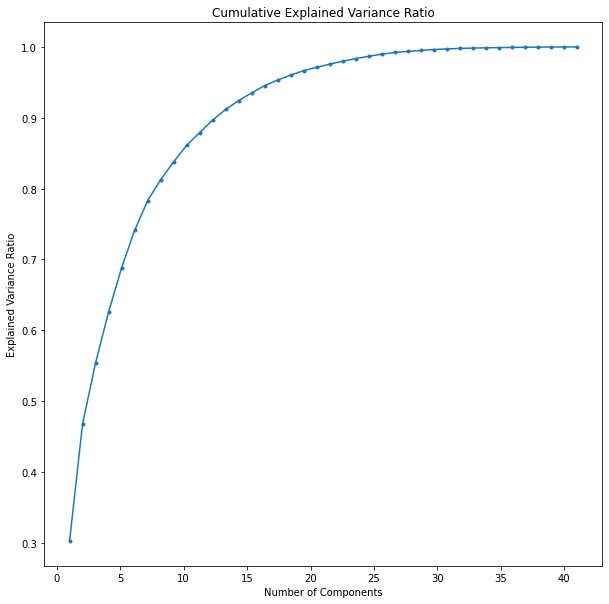

In [10]:
pca = PCA()

feature_1_pca = pca.fit_transform(feature_1)

n_components = np.linspace(1, 41, 40)
cum_exp_variance_ratio = np.cumsum(pca.explained_variance_ratio_[ :40])

plt.figure(figsize = (10, 10))
plt.plot(n_components, cum_exp_variance_ratio, marker = "o", markersize = 3)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio")

plt.show()

In [11]:
feature_pca = pd.DataFrame(feature_1_pca[:, 0: 15])

print('Number of features extracted:', feature_pca.shape[1])
print(110*'-')

Number of features extracted: 15
--------------------------------------------------------------------------------------------------------------


The graph above is a plot of the cumulative variance as we keep adding or including the princiapl components. Based on this graph, it seems that the first 15 components have a variance ratio as 0.975. Therefore, for our study we will use the first 15 principal components. 

Therefore, for this report, I would like to consider the dimensioinally reduced matrix with 15 components.

### 3.5.2 Variance Threshold

In [12]:
#Source: FML II Seminar conducted by Adamantios Ntakaris at the University of Edinburgh

# Create thresholder
thresholder = VarianceThreshold(threshold = 0.001)
# Create high variance feature matrix
features_high_va = thresholder.fit_transform(feature_pca)

print('Number of features extracted:', features_high_va.shape[1])
print(110*'-')

Number of features extracted: 15
--------------------------------------------------------------------------------------------------------------


In [13]:
#Source: FML II Seminar conducted by Adamantios Ntakaris at the University of Edinburgh

# Create thresholder
thresholder = VarianceThreshold(threshold = 0.01)
# Create high variance feature matrix
features_high_va = thresholder.fit_transform(feature_pca)

print('Number of features extracted:', features_high_va.shape[1])
print(110*'-')

Number of features extracted: 7
--------------------------------------------------------------------------------------------------------------


It is noted above that the variance threshold is quite low, wherein at threshold of 0.01 we eliminate no features and at threshold 0.001 we elimiate 11 features.

**Mean Absolute Difference**

In [14]:
#Source: FML II Seminar conducted by Adamantios Ntakaris at the University of Edinburgh

features_mad = np.sum(np.abs(feature_pca - np.mean(feature_pca, axis=0)), axis=0)/feature_pca.shape[0]

mad_threshold = 0.01
features_mad = features_mad[features_mad.iloc[0: ] > mad_threshold]

print('Number of features extracted:', features_mad.shape[0])
print(110*'-')

Number of features extracted: 15
--------------------------------------------------------------------------------------------------------------


It is noted above that at absolute difference level of 0.01, no features are eliminated i.e. the threshold is very small.

**Correlation based Method**

In [15]:
#Source: FML II Seminar conducted by Adamantios Ntakaris at the University of Edinburgh

# Create correlation matrix
corr_matrix = feature_pca.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.05
to_drop = [column for column in upper.columns if any(upper[column] > 0.05)]

# Drop features
feature_corr = feature_pca.drop(feature_pca.columns[to_drop], axis=1)

print('Number of features extracted:', feature_corr.shape[1])
print(110*'-')

Number of features extracted: 15
--------------------------------------------------------------------------------------------------------------


/var/folders/k5/d2cms8mj3m3b09hjpq3tt_tc0000gn/T/ipykernel_9022/3597637378.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))


High correlation between features would justify elimiating features, since uncorrelated features will provide a more robust result. It is noted that even at correlation threshold of 0.05, all the features selected through PCA are retained.

**Conclusion** <br> Based on the feature matrix extracted through PCA and additional methods applied to further reduce the features, the feature list obtained through PCA seems a reasonable choice.

In this study, we will therefore proceed with the features selected through PCA.

# 2. Model Run

## 2.1 Naive Bayes

In [16]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    model1 = GaussianNB()
    model1.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_tr = model1.predict(X_train)
    y_pred_te = model1.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m1_te = np.mean(acc_te)
avg_prec_m1_te = np.mean(prec_te)
avg_recall_m1_te = np.mean(recall_te)
avg_f1_m1_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m1_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m1_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m1_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m1_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.972389
Precision Score: 0.996178
Recall Score: 0.974449
F1 Score: 0.984677


## 2.2 Logistic Regression

In [17]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    model2 = LogisticRegression(max_iter = 200)
    model2.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model2.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m2_te = np.mean(acc_te)
avg_prec_m2_te = np.mean(prec_te)
avg_recall_m2_te = np.mean(recall_te)
avg_f1_m2_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m2_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m2_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m2_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m2_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


## 2.3 Support Vector Regression (kernal = 'linear')

In [18]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    model3 = SVC(kernel = 'linear')
    model3.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model3.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)

    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m3_te = np.mean(acc_te)
avg_prec_m3_te = np.mean(prec_te)
avg_recall_m3_te = np.mean(recall_te)
avg_f1_m3_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m3_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m3_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m3_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m3_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


## 2.4 Support Vector Regression (kernal = 'radial basis function')

In [19]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    model4 = SVC(kernel = 'rbf', gamma='auto')
    model4.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model4.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)

    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m4_te = np.mean(acc_te)
avg_prec_m4_te = np.mean(prec_te)
avg_recall_m4_te = np.mean(recall_te)
avg_f1_m4_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m4_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m4_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m4_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m4_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


## 2.5 Support Vector Regression (kernal = 'polynomial with degree 4')

In [20]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    model5 = SVC(kernel = 'poly', gamma='auto', degree = 4)
    model5.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model5.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m5_te = np.mean(acc_te)
avg_prec_m5_te = np.mean(prec_te)
avg_recall_m5_te = np.mean(recall_te)
avg_f1_m5_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m5_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m5_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m5_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m5_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


## 2.6 Support Vector Regression (kernal = 'sigmoid')

In [21]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    model6 = SVC(kernel='sigmoid',gamma='auto')
    model6.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model6.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m6_te = np.mean(acc_te)
avg_prec_m6_te = np.mean(prec_te)
avg_recall_m6_te = np.mean(recall_te)
avg_f1_m6_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m6_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m6_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m6_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m6_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


# 3. Boosting Methods 

## 3.1 Adaboost Classifer

### 3.1.3 Naive Bayes

In [22]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    gnb = GaussianNB()
    model7 = AdaBoostClassifier(n_estimators = 5, base_estimator = gnb, learning_rate = 1)
    model7.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model7.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m7_te = np.mean(acc_te)
avg_prec_m7_te = np.mean(prec_te)
avg_recall_m7_te = np.mean(recall_te)
avg_f1_m7_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m7_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m7_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m7_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m7_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.787395
Precision Score: 0.791043
Recall Score: 0.795972
F1 Score: 0.793476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.1.3 Logistic Regression

In [23]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #returns = pd.DataFrame(returns)
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    lgr = LogisticRegression(max_iter = 200)
    model8 = AdaBoostClassifier(n_estimators = 5, base_estimator = lgr, learning_rate = 1)
    model8.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model8.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m8_te = np.mean(acc_te)
avg_prec_m8_te = np.mean(prec_te)
avg_recall_m8_te = np.mean(recall_te)
avg_f1_m8_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m8_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m8_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m8_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m8_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


### 3.1.3 Support Vector Regression (kernal = 'linear')

In [24]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    svc = SVC(kernel = 'linear')
    model9 = AdaBoostClassifier(n_estimators = 5, algorithm='SAMME', base_estimator = svc, learning_rate = 1)
    model9.fit(X_train, y_train) 
    
    # Predicted Labels
    y_pred_te = model9.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m9_te = np.mean(acc_te)
avg_prec_m9_te = np.mean(prec_te)
avg_recall_m9_te = np.mean(recall_te)
avg_f1_m9_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m9_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m9_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m9_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m9_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


### 3.1.3 Support Vector Regression (kernal = 'rbf')

In [25]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    svc = SVC(kernel = 'rbf', gamma='auto')
    model10 = AdaBoostClassifier(n_estimators = 5, algorithm='SAMME', base_estimator = svc, learning_rate = 1)
    model10.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model10.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m10_te = np.mean(acc_te)
avg_prec_m10_te = np.mean(prec_te)
avg_recall_m10_te = np.mean(recall_te)
avg_f1_m10_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m10_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m10_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m10_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m10_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


### 3.1.4 Support Vector Regression (kernal = 'polynomial with degree 4')

In [26]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    svc = SVC(kernel = 'poly', gamma='auto', degree = 4)
    model11 = AdaBoostClassifier(n_estimators = 5, algorithm='SAMME', base_estimator = svc, learning_rate = 1)
    model11.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model11.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m11_te = np.mean(acc_te)
avg_prec_m11_te = np.mean(prec_te)
avg_recall_m11_te = np.mean(recall_te)
avg_f1_m11_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m11_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m11_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m11_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m11_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


### 3.1.5 Support Vector Regression (kernal = 'rbf')

In [27]:
#Source: PRFD Seminar conducted by Adamantios Ntakaris at the University of Edinburgh
# Source: scikit learn documentation

tscv = TimeSeriesSplit()

counter = 0

acc_te = []
prec_te = []
recall_te = []
f1_te = []

for train_index, test_index in tscv.split(feature_pca):
    
    counter += 1
    
    print(100*'.')
    print('\nFold %d:' %counter)
    
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    #Split data into training and test set
    X_train, X_test = feature_pca.iloc[train_index,:], feature_pca.iloc[test_index,:]
    y_train, y_test = returns.iloc[train_index], returns.iloc[test_index]
       
    svc = SVC(kernel='sigmoid',gamma='auto')
    model12 = AdaBoostClassifier(n_estimators = 5, algorithm='SAMME', base_estimator = svc, learning_rate = 1)
    model12.fit(X_train, y_train)
    
    # Predicted Labels
    y_pred_te = model12.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred_te)
    prec_test = precision_score(y_test, y_pred_te)
    recall_test = recall_score(y_test, y_pred_te)
    f1_test = f1_score(y_test, y_pred_te)
    
    acc_te.append(acc_test)
    prec_te.append(prec_test)
    recall_te.append(recall_test)
    f1_te.append(f1_test)
    
avg_acc_m12_te = np.mean(acc_te)
avg_prec_m12_te = np.mean(prec_te)
avg_recall_m12_te = np.mean(recall_te)
avg_f1_m12_te = np.mean(f1_te)

print("\nAccuracy Score: {}".format(round(avg_acc_m12_te, 6)))
print("Precision Score: {}".format(round(avg_prec_m12_te, 6)))
print("Recall Score: {}".format(round(avg_recall_m12_te, 6)))
print("F1 Score: {}".format(round(avg_f1_m12_te, 6)))

....................................................................................................

Fold 1:
TRAIN: 1670 TEST: 1666
....................................................................................................

Fold 2:
TRAIN: 3336 TEST: 1666
....................................................................................................

Fold 3:
TRAIN: 5002 TEST: 1666
....................................................................................................

Fold 4:
TRAIN: 6668 TEST: 1666
....................................................................................................

Fold 5:
TRAIN: 8334 TEST: 1666

Accuracy Score: 0.990756
Precision Score: 0.990756
Recall Score: 1.0
F1 Score: 0.995269


# 3. Model Outputs 

## 3.1 Performance Metrics (Iteration 1)

In [28]:

model_metric_te = {'Accuracy':[avg_acc_m1_te, avg_acc_m2_te, avg_acc_m3_te, avg_acc_m4_te, avg_acc_m5_te, avg_acc_m6_te],
                   'Precision':[avg_prec_m1_te, avg_prec_m2_te, avg_prec_m3_te, avg_prec_m4_te, avg_prec_m5_te, avg_prec_m6_te],
                    'Recall':[avg_recall_m1_te, avg_recall_m2_te, avg_recall_m3_te, avg_recall_m4_te, avg_recall_m5_te, avg_recall_m6_te],
                    'F1 Score':[avg_f1_m1_te, avg_f1_m2_te, avg_f1_m3_te, avg_f1_m4_te, avg_f1_m5_te, avg_f1_m6_te]}
                
# Creates pandas DataFrame.
result_summary = pd.DataFrame(model_metric_te, index =['Naive Bayes',
                                                       'Logistic Regression',
                                                       'SVC (linear)',
                                                       'SVC (rbf)',
                                                       'SVC (poly = 4)',
                                                       'SVC (sigmoid)'])                                    
 
# print the data
display(result_summary)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.972389,0.996178,0.974449,0.984677
Logistic Regression,0.990756,0.990756,1.000000,0.995269
SVC (linear),0.990756,0.990756,1.000000,0.995269
SVC (rbf),0.990756,0.990756,1.000000,0.995269
SVC (poly = 4),0.990756,0.990756,1.000000,0.995269
SVC (sigmoid),0.990756,0.990756,1.000000,0.995269


## 3.2 Performance Metrics (Iteration 2)

In [29]:

model_metric_te = {'Accuracy':[avg_acc_m7_te, avg_acc_m8_te, avg_acc_m9_te, avg_acc_m10_te, avg_acc_m11_te, avg_acc_m12_te],
                   'Precision':[avg_prec_m7_te, avg_prec_m8_te, avg_prec_m9_te, avg_prec_m10_te, avg_prec_m12_te, avg_prec_m12_te],
                    'Recall':[avg_recall_m7_te, avg_recall_m8_te, avg_recall_m9_te, avg_recall_m10_te, avg_recall_m11_te, avg_recall_m12_te],
                    'F1 Score':[avg_f1_m7_te, avg_f1_m8_te, avg_f1_m9_te, avg_f1_m10_te, avg_f1_m11_te, avg_f1_m12_te]}
                
# Creates pandas DataFrame.
result_summary = pd.DataFrame(model_metric_te, index =['Naive Bayes',
                                                       'Logistic Regression',
                                                       'SVC (linear)',
                                                       'SVC (rbf)',
                                                       'SVC (poly = 4)',
                                                       'SVC (sigmoid)'])                                    
 
# print the data
display(result_summary)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.787395,0.791043,0.795972,0.793476
Logistic Regression,0.990756,0.990756,1.000000,0.995269
SVC (linear),0.990756,0.990756,1.000000,0.995269
SVC (rbf),0.990756,0.990756,1.000000,0.995269
SVC (poly = 4),0.990756,0.990756,1.000000,0.995269
SVC (sigmoid),0.990756,0.990756,1.000000,0.995269


# 4. Final Prediction

#Predictions
pred_1 = model8.predict(X_test)
pred_2 = model9.predict(X_test)
pred_3 = model10.predict(X_test)

In [30]:
pred_1 = model1.predict(X_test)
pred_2 = model8.predict(X_test)
pred_3 = model9.predict(X_test)
pred_4 = model10.predict(X_test)
pred_5 = model11.predict(X_test)
pred_6 = model12.predict(X_test)

## 4.1 Averaging

In [31]:
final_pred_avg = np.round((pred_1 + pred_2 + pred_3 + pred_4 + pred_5 + pred_6)/ 6,0)

accuracy_score(y_test, final_pred_avg)

0.9537815126050421

## 4.2 Weighted Average

In [32]:
total_acc = (avg_acc_m1_te + avg_acc_m7_te + avg_acc_m8_te + avg_acc_m9_te + avg_acc_m10_te)

w_acc_1 = avg_acc_m1_te/total_acc
w_acc_2 = avg_acc_m8_te/total_acc
w_acc_3 = avg_acc_m9_te/total_acc
w_acc_4 = avg_acc_m10_te/total_acc
w_acc_5 = avg_acc_m11_te/total_acc
w_acc_6 = avg_acc_m12_te/total_acc

final_pred_wavg = np.round((w_acc_1 * pred_1 +
                            w_acc_2 * pred_2 +
                            w_acc_3 * pred_3 +
                            w_acc_4 * pred_4 +
                            w_acc_5 * pred_5 +
                            w_acc_6 * pred_6))

accuracy_score(y_test, final_pred_wavg)

0.9537815126050421

In [33]:
print(50*'.')
print("\nCode has run")
print(50*'.')

..................................................

Code has run
..................................................
